### Initialise

In [1]:
## Import necessary packages
import time;
import numpy as np; 
import matplotlib.pyplot as plt; 
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import python.data as datameta

In [2]:
# Basic Initialisations
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


### Preprocess Data

In [3]:
data = datameta.processData('../data/clean_data.csv'); 
data.head()

Index(['Time (h)', 'Aeration rate(Fg:L/h)', 'Sugar feed rate(Fs:L/h)',
       'Acid flow rate(Fa:L/h)', 'Base flow rate(Fb:L/h)',
       'Air head pressure(pressure:bar)', 'Substrate concentration(S:g/L)',
       'Penicillin concentration(P:g/L)', 'Vessel Volume(V:L)', 'pH(pH:pH)',
       'Temperature(T:K)', 'PAA flow(Fpaa:PAA flow (L/h))',
       'Oil flow(Foil:L/hr)', 'Ammonia shots(NH3_shots:kgs)', 'Water Flow'],
      dtype='object') 

 (113935, 15)


,Time (h),Aeration rate(Fg:L/h),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Air head pressure(pressure:bar),Substrate concentration(S:g/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),pH(pH:pH),Temperature(T:K),PAA flow(Fpaa:PAA flow (L/h)),Oil flow(Foil:L/hr),Ammonia shots(NH3_shots:kgs),Water Flow
0,0.000000,0.181818,0.040541,0.000000,0.133858,0.0,0.008306,1.791808e-27,0.049276,0.767126,0.258427,0.333333,0.0,0.0,0.004470
1,0.000690,0.181818,0.040541,0.000000,0.227649,0.0,0.008715,2.763729e-05,0.049480,0.800686,0.249064,0.333333,0.0,0.0,0.008252
2,0.001380,0.181818,0.040541,0.000000,0.241342,0.0,0.009107,2.761905e-05,0.049685,0.836653,0.243446,0.333333,0.0,0.0,0.004363
3,0.002070,0.181818,0.040541,0.000000,0.168071,0.0,0.009492,2.760247e-05,0.049787,0.860582,0.237828,0.333333,0.0,0.0,0.001972
4,0.002761,0.181818,0.040541,0.039866,0.084036,0.0,0.009864,2.758782e-05,0.049838,0.865835,0.234082,0.333333,0.0,0.0,0.000502


In [4]:
# Split into x and y
x_keys = [
    "Time (h)", "Aeration rate(Fg:L/h)", "Sugar feed rate(Fs:L/h)","Acid flow rate(Fa:L/h)",
    "Base flow rate(Fb:L/h)","Water Flow","Substrate concentration(S:g/L)","PAA flow(Fpaa:PAA flow (L/h))",
    "Oil flow(Foil:L/hr)", "Ammonia shots(NH3_shots:kgs)",
    # Converted variables
    "Air head pressure(pressure:bar)", "Temperature(T:K)", "pH(pH:pH)", "Vessel Volume(V:L)"
]
(x,y) = datameta.xy_split(data,x_keys)

x:  14  keys in  14 cols
y:  1  keys in  1 cols


In [5]:
rand = round(time.time() * 1000) % 100; 
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=rand)

print ("x_train: ", x_train.shape)
print ("x_test: ", x_test.shape)

print ("y_train: ", y_train.shape)
print ("y_test: ", y_test.shape)

x_train:  (102541, 14)
x_test:  (11394, 14)
y_train:  (102541, 1)
y_test:  (11394, 1)


In [6]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.x.shape[0]
       
    def __getitem__(self, index):
        return self.x[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 32

# Instantiate training and test data
train_data = Data(x_train.to_numpy(), y_train.to_numpy())
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(x_test.to_numpy(), y_test.to_numpy())
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [7]:
# Just checking if it worked
for batch, (x, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {x.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([32, 14])
y shape: torch.Size([32, 1])


In [8]:
input_dim = len(x_keys)
hidden_dim = 950
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = self.layer_2(x)

        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=14, out_features=950, bias=True)
  (layer_2): Linear(in_features=950, out_features=1, bias=True)
)


In [9]:
learning_rate = 0.00001
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

Training Complete


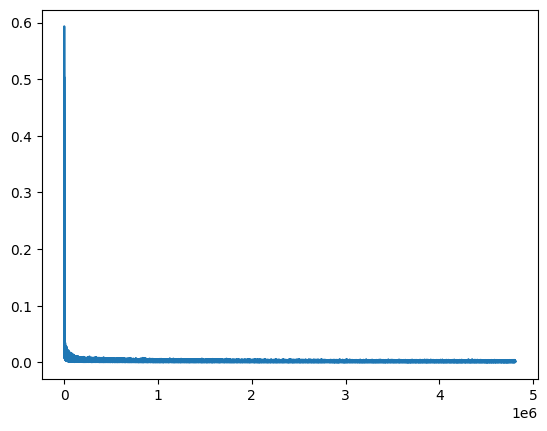

In [10]:
num_epochs = 1500
loss_values = []


for epoch in range(num_epochs):
    for x, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(x)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        # scheduler.step()

# plt.plot(loss_values[500:])
plt.plot(loss_values)
print("Training Complete")

In [11]:
total = 0.0
correct = 0.0
y_pred = []

def isClose(base, known, tol):
    return np.abs((base - known) / base) <= tol

with torch.no_grad():
    for x, y in test_dataloader:
        outputs = model(x)
        np.append(y_pred, outputs)
        np.append(y_test, y)
        # y_pred.append(predicted)
        # y_test.append(y)
        total += y.size(0)
        correct += np.sum(isClose(outputs.numpy(), y.numpy(), tol=0.001))

print(f'Accuracy out of {total} test instances: {(100 * correct) / total}%')

Accuracy out of 11394.0 test instances: 0.7986659645427417%


In [2]:
x = range(4,9,1)
list(x)

[4, 5, 6, 7, 8]